## Analyze A/B Test Results



## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.  It is important that to get some practice working with the difficulties of these 

For this project, I will be working to understand the results of an A/B test run by an e-commerce website.  The goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.


<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

`1.` Now, read in the `ab_data.csv` data. Store it in `df`.  **Use your dataframe to answer the questions in Quiz 1 of the classroom.**

a. Read in the dataset and take a look at the top few rows here:

In [2]:
# Dataframe for AB test data
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


> This dataset is composed of:
> 1. Users who visit e-commerce site, recognizable by a unique id: user_id
> 2. The time at which the user visits the landing page: timestamp
> 3. The group of which the user is part, control (in general control is when you keep this user in the same experience as before) and treatment : group
> 4. The landing page on which the user ends up, old_page or new_page: landing_page
> 5. Information if the user was converted or not, 1 or 0: converted

*First toughts: This type of dataset will allow us to find out the conversion rate of users and compare which is the landing page (old or new) that has the most succesful conversion rate. The control group experience can be compared with the treatment group's experience. It will also be possible to analyze the impact of the time of day on the conversion rate.*

b. Use the cell below to find the number of rows in the dataset.

In [3]:
# Get number of rows and columns in the df
df.shape

(294478, 5)

c. The number of unique users in the dataset.

In [4]:
# Unique user id's in the df
df.user_id.nunique()

290584

>we find that user id(s) can be repeated accross the dataset as there are less user_id than number of rows. So, some of them came back during the AB test. Although, let's just check that the experience is not duplicated

In [5]:
# Check if duplicated rows in the dataset
df[df.duplicated()]

,user_id,timestamp,group,landing_page,converted


> no duplicated rows found

d. The proportion of users converted.

In [6]:
# Find proportion of users who converted at each test
# Assumption: each test is represented by one row
# Note: it means that if a user comes back and is converted several times
# then, we count it too
p = round(df.converted.sum()/df.shape[0],2) 
p

0.12

e. The number of times the `new_page` and `treatment` don't match.

In [7]:
#In order to get a broader perspective on the tests

# Check how much each group lands on the new page
print("Users who land on *New page*:")
print(df.query('landing_page == "new_page"').groupby('group').size())
print('_____________________')
# Check how much each group lands on the old page
print("Users who land on *Old page*:")
print(df.query('landing_page == "old_page"').groupby('group').size())

Users who land on *New page*:
group
control        1928
treatment    145311
dtype: int64
_____________________
Users who land on *Old page*:
group
control      145274
treatment      1965
dtype: int64


In [8]:
# Number of times new_page and treatment do not match
df.query('landing_page == "new_page" & group == "control" | landing_page == "old_page" & group == "treatment" ').user_id.count()



3893

f. Do any of the rows have missing values?

In [9]:
# Find rows that have null values
df[df.isna().any(axis=1)]

,user_id,timestamp,group,landing_page,converted


`2.` For the rows where **treatment** does not match with **new_page** or **control** does not match with **old_page**, we cannot be sure if this row truly received the new or old page.  Use **Quiz 2** in the classroom to figure out how we should handle these rows.  

a. Now use the answer to the quiz to create a new dataset that meets the specifications from the quiz.  Store your new dataframe in **df2**.

> In order to not induce error in the analysis, we need to drop the rows that have inconsistant results. Indeed, the control group is supposed to be the group of users for which experience in the site stays the same, which means the control group should only land in old_page. And reversely, for the treatment group, it should only land in the new_page. Therefore, we do not want to alter the conversion rate calculation with errors in the experimentation. 

In [10]:
# Get index of rows to drop = rows where control group lands in new_page and treatment group lands in old page
index_to_drop = df.query('landing_page == "new_page" & group == "control" | landing_page == "old_page" & group == "treatment" ').index

# Drop the rows
df2 = df.drop(index_to_drop, axis = 0)
# Reset index to restart index count
df2.reset_index(drop = True, inplace= True)
# Check that the dataframe looks like we expect
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290585 entries, 0 to 290584
Data columns (total 5 columns):
user_id         290585 non-null int64
timestamp       290585 non-null object
group           290585 non-null object
landing_page    290585 non-null object
converted       290585 non-null int64
dtypes: int64(2), object(3)
memory usage: 11.1+ MB


In [11]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` Use **df2** and the cells below to answer questions for **Quiz3** in the classroom.

a. How many unique **user_id**s are in **df2**?

In [12]:
# Check how many distinct user_id are there
df2.user_id.nunique()

290584

> When checking the df2.info() above, we see there are 290585 entries but there are only 290584 unique user_id. It means that one user_id is duplicated

b. There is one **user_id** repeated in **df2**.  What is it?

In [13]:
# Which user_id is duplicated ?
df2[df2.user_id.duplicated()]

,user_id,timestamp,group,landing_page,converted
2862,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


c. What is the row information for the repeat **user_id**? 

In [14]:
# Which are the rows where the duplicated user_id appears ?
df2[df2['user_id'] == 773192 ]

,user_id,timestamp,group,landing_page,converted
1876,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2862,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [15]:
# Drop one of the rows of the duplicated user
df2.drop([2862], axis = 0, inplace = True)

In [16]:
# Check that this user_id only has one row in the dataframe
df2[df2['user_id'] == 773192 ]

,user_id,timestamp,group,landing_page,converted
1876,773192,2017-01-09 05:37:58.781806,treatment,new_page,0


`4.` Use **df2** in the cells below to answer the quiz questions related to **Quiz 4** in the classroom.

a. What is the probability of an individual converting regardless of the page they receive?

>df2 is now our reference dataset as it has been cleaned and made ready for the next part of the analysis

In [17]:
# Proportion of people converted among the overall dataset
p_c = round(df2.converted.sum()/df2.shape[0],4)
p_c

0.1196

b. Given that an individual was in the `control` group, what is the probability they converted?

In [18]:
# Proportion of people belonging to control group who converted
df2_con = df2[df2['group'] == "control"]
p_c_con = df2_con.converted.sum()/df2_con.shape[0]
p_c_con

0.1203863045004612

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [19]:
# Proportion of people belonging to treatment group who converted
df2_treat = df2[df2['group'] == "treatment"]
p_c_treat = df2_treat.converted.sum()/df2_treat.shape[0]
p_c_treat

0.11880806551510564

d. What is the probability that an individual received the new page?

In [20]:
# Proportion of users classified in treatment group 
df2.query('group == "treatment"').user_id.count()/df2.shape[0]

0.50006194422266881

In [21]:
# Compute the observed difference probability for users to convert 
# between new and old pages
obs_diff = p_c_treat - p_c_con

# Display observed difference based on previous values in excercise part I
obs_diff

-0.0015782389853555567

e. Consider your results from parts (a) through (d) above, and explain below whether you think there is sufficient evidence to conclude that the new treatment page leads to more conversions.

**The new treatment page according to our probabilities is hardly showing any improvement at all compared with the old page. The probability to convert for people in the treatment group is 11.8% and for people in the control group, it is 12.0% which can be considered exactly the same probability of conversion whether the landing page is the new or the old one. There is no significant difference that we can consider at this point. In conclusion, there is no sufficient evidence that shows that there is a difference between old and new page conversion**

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

$$ H_{0}: p_{new} - p_{old} ≤ 0 $$
$$ H_{1}: p_{new} - p_{old} > 0 $$

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

Use the cells below to provide the necessary parts of this simulation.  If this doesn't make complete sense right now, don't worry - you are going to work through the problems below to complete this problem.  You can use **Quiz 5** in the classroom to make sure you are on the right track.<br><br>

In [22]:
# The dataframe we use for this A/B test
df2.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


a. What is the **conversion rate** for $p_{new}$ under the null? 

The conversion rate "under the null" means that we are looking for the value of the conversion rate knowing that it respects the equation from the null hypothesis $$ H_{0}: p_{new} - p_{old} ≤ 0 $$ 

In [23]:
# Calculation of number of conversions for treatment group assuming null hypothesis
p_new_null = round(df2.converted.sum()/df2.shape[0],4)
p_new_null

0.1196

b. What is the **conversion rate** for $p_{old}$ under the null? <br><br>

In [24]:
# Calculation of number of conversions for control group assuming null hypothesis
p_old_null = p_new_null
p_old_null

0.1196

c. What is $n_{new}$, the number of individuals in the treatment group?

In [25]:
# dataset keeping only treatment group
df2_new = df2[df2['group'] == "treatment"]
# count unique users in the treatment group
n_new = df2_new.user_id.nunique()
n_new

145310

d. What is $n_{old}$, the number of individuals in the control group?

In [26]:
# dataset keeping only control group
df2_old = df2[df2['group'] == "control"]
# count unique users in the control group
n_old = df2_old.user_id.nunique()
n_old

145274

e. Simulate $n_{new}$ transactions with a conversion rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [27]:
# Use numpy function to simulate "coin flips" representing conversion for treatment group
   # determine the size of this simulation by the number of users in the treatment group
   # determine the probability of "success" by the conversion rate for treatment group under the null hypothesis
new_page_converted = np.random.choice([0,1], size = n_new, p = [1 - p_new_null, p_new_null])

new_page_converted

array([0, 0, 0, ..., 0, 0, 0])

f. Simulate $n_{old}$ transactions with a conversion rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [28]:
# Use numpy function to simulate "coin flips" representing conversion for control group 
   # determine the size of this simulation by the number of users in the control group
   # determine the probability of "success" by the conversion rate for control group under the null hypothesis
old_page_converted = np.random.choice([0,1], size = n_old, p = [1 - p_old_null, p_old_null])

old_page_converted

array([0, 0, 0, ..., 0, 0, 0])

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [29]:
# Calculate conversion rate for treatment group obtained by simulation
p_new_sim = new_page_converted.sum()/len(new_page_converted)
# Caluculate conversion rate for treatment group obtained by simulation
p_old_sim = old_page_converted.sum()/len(old_page_converted)

# Calculate observed difference in conversion rates assuming null 
obs_diff_null = p_new_sim - p_old_sim 
obs_diff_null

-0.0006217264871164474

>The difference in conversion rates is insignificant and suppport previous results as well as the correctness of the null hypothesis that has been used as a reference for this simulation

h. Create 10,000 $p_{new}$ - $p_{old}$ values using the same simulation process you used in parts (a) through (g) above. Store all 10,000 values in a NumPy array called **p_diffs**.

In [30]:
# Array for statistics which will be calculated in the loop to compare to hypothesis
p_diffs = []

# Simulation of 10000 times the coin flips with same technique as used above in the notebook
for i in range(10000):
    new_page_converted = np.random.choice([0,1], size = n_new, p = [1 - p_new_null, p_new_null])
    old_page_converted = np.random.choice([0,1], size = n_old, p = [1 - p_old_null, p_old_null])
    p_new_sim = new_page_converted.sum()/len(new_page_converted)
    p_old_sim = old_page_converted.sum()/len(old_page_converted)
    p_diffs.append(p_new_sim - p_old_sim)

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

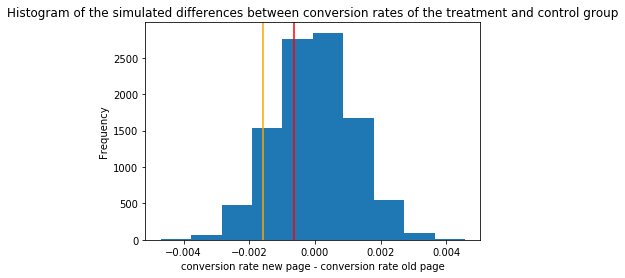

In [31]:
# Plot the histogram of the simulated differences between conversion rates
plt.hist(p_diffs);
# Mark in orange the observed difference statistic obtained thanks to excercise Part I question 4
plt.axvline( x = obs_diff, color = 'orange');
# Mark in red the observed difference statistic obtained under the simulated null hypothesis
plt.axvline( x = obs_diff_null, color = 'r');
# Format the vizualisation
plt.title("Histogram of the simulated differences between conversion rates of the treatment and control group")
plt.xlabel("conversion rate new page - conversion rate old page")
plt.ylabel("Frequency");

- In orange:  the observed difference statistic obtained thanks to excercise Part I question 4
- In red: the observed difference statistic obtained under the simulated null hypothesis

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [32]:
# Proportion of differences in conversion rates that are greater 
#than the observed actual difference between treatment and control groups
(p_diffs > obs_diff).mean()

0.90469999999999995

>The proportion of differences in conversion rates that are greater than the observed actual difference between treatment and control groups is large. What does this mean? 
1. We are using a simulation of statistics based on the null hypothesis
2. The null hypothesis states that conversion for treatment group is either less high or equal to conversion for control group
3. This proportion calculated (also called p-value) represents the likelihood to find our observed statistic or an even more extreme value in favor of hypothesis 1 in this sampling distribution.

**> It is very likely to find our conversion rate out from the null hypothesis**

k. Please explain using the vocabulary you've learned in this course what you just computed in part **j.**  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

**We have been applying the Hypothesis testing technique in this part of the excercise. The hypothesis testing method is used in this case to identify whether a new feature in the website is going to have the expected outcome or not. We tested whether the new landing page has a better conversion rate than the old one. We used the null hypothesis assuming it is true in order to compare it to the observed value drawned from the data. In doing so, we obtain the p-value, the probability to obtain the observed statistic under the null hypothesis or one more extreme in favor of the alternative hypothesis. We compute the p-value by looking at more extreme values that could relate to the alternative hypothesis. Knowing the null hypothesis is that the new page conversion is equal or worse than the old page conversion, if the p-value is high, then there is high chances that the null hypothesis is True. So, our test bring us to the conclusion that the new page has a conversion equal or worse than the old page**

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [33]:
import statsmodels.stats.proportion as sm
# Number of conversions for control group (using previously computed dataset)
convert_old = df2_old.converted.sum()
# Number of conversions for treatment group (using previously computed dataset)
convert_new = df2_new.converted.sum()
# Number of "trials/tests for conversion" for control group (using previously computed dataset)
n_old = df2_old.shape[0]
# Number of "trials/tests for conversion" for treatment group (using previously computed dataset)
n_new = df2_new.shape[0]

m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](http://knowledgetack.com/python/statsmodels/proportions_ztest/) is a helpful link on using the built in.

In [34]:
# Proportion z_test standardized function - 1st way of using it
stat, pval = sm.proportions_ztest([convert_new, convert_old], [n_new, n_old], alternative = "larger")
# P-value
print('{0:0.3f}'.format(pval))

0.905


In [35]:
# Proportion z_test standardized function - 2nd way of using it
sm.proportions_ztest([convert_new,convert_old], [n_new, n_old], alternative= "larger")
# Resulting in (z-score, p-value)

(-1.3109241984234394, 0.90505831275902449)

Note: We have to use the parameter of the z_test function called "alternative" and set it as *larger* because 

> The z-score determines the position of the raw score by its distance to the mean in standard deviation units. If it is negative, it means the value of the raw score lies below the mean. The mean here being 0, the raw score (or which could be called observed difference) is 1.3 standard deviations below the mean.

n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

**The overall standard z-test is aligned with the findings simulating distributions under the null hypothesis.**
1. z-score is aligned with the unaltered observed difference from the data (orange bar in par i of excercise) *$$ p_{new} - p_{old}$$* which finds itself a little bit below the mean (the standard deviation is though such a close value to zero that in practical terms it is as if it was zero)
2. p-value is aligned with the value also found in the simulation of the null hypothesis. It gives us a strong probability to find our observed difference in conversion rates under the null hypthesis. 

**In conclusion it means that the standardized test of z-proportions supports the fact that the conversion rates for the new page are equal (or slightly lower) than conversion rates for the old page.**

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you achieved in the A/B test in Part II above can also be achieved by performing regression.<br><br> 

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

**A logistic regression makes sense because**
- there are multiple variables (categorical and quantitative) that influence the prediction we want to make about conversion of a user. 
- The prediction is about a binary variable: Will there be a conversion or no conversion? 

**So for that 2nd reason we do not use multiple linear regression, but logistic regression**

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives. However, you first need to create in df2 a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [36]:
#Import necessary packages for statsmodels to perform a logistic regression
#Statsmodel package
import statsmodels.api as sm


/opt/conda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [37]:
# Check the dataset to use in this regression excercise
df2.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [38]:
#Create the intercept for the logistic model 
df2['intercept'] = 1
# Create dummies for the categorical variable 'group'
df2[['control', 'ab_page']] = pd.get_dummies(df2['group'])
# Drop the column we will not use in the analysis
df2.drop(columns='control', inplace= True)
# Verify the dataset looks like we expect
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0


c. Use **statsmodels** to instantiate your regression model on the two columns you created in part b., then fit the model using the two columns you created in part **b.** to predict whether or not an individual converts. 

In [39]:
#Define response and explanatory variables
y = df2['converted']
X = df2[['intercept','ab_page']]

In [40]:
# Instantiate the logistic regression
logit_mod = sm.Logit(y, X)
# Fit the logistic model
result = logit_mod.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [41]:
# Summary of logistic regression performed above
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Mon, 13 Jan 2020   Pseudo R-squ.:               8.077e-06
Time:                        14:44:31   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

In [42]:
# Odds to convert based on baseline
np.exp(-0.0150)

0.98511193960306265

In [43]:
# Odds to convert for control group
1/np.exp(-0.0150)

1.0151130646157189

> If an individual is in the treatment group, he is 0.98 times as likely to convert than if he were in the control group

>If an individual is in the control group, he is 1.01 times more likely to convert than if he were in the treatment group

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>  **Hint**: What are the null and alternative hypotheses associated with your regression model, and how do they compare to the null and alternative hypotheses in **Part II**?


__Hypothesis in hypothesis AB testing excercise__
$$ H_{0}: p_{new} - p_{old} ≤ 0 $$
$$ H_{1}: p_{new} - p_{old} > 0 $$

*The null hypothesis here is testing whether the difference in conversion from the treatment and control group are smaller or equal to zero. And the alternative hypothesis is checking if the difference in conversion is higher than zero. The p-value for this test has proven to have a high value. It means that the p-value supports the null hypothesis. Hence, the new page has the same or a worse conversion rate than the old page.*

__Hypothesis in regression excercise__ 

- $$\beta1$$ is the factor determining how much ab_page (treatment or control group) affects the model
$$ H_{0}: \beta1 = 0 $$
$$ H_{1}:\beta1 \neq 0 $$

*If beta1 is zero then, the fact to be in the control of treatment group does not affect the conversion. It would mean that ab_page is not very significant for our model. So if the p-value supports the null hypothesis (if it is higher than 0) then there is a chance that the parameter is not statistically significant at predicting the conversion.*

*In the results, we observe that the p-value is 0.19. It means that there is 19% chance to find the observed value in the null hypothesis. However this p-value is not extremely high at supporting the null. So it implies that there is a slight statistical significance for someone to be in the treatment or control group when predicting the conversion of a user.*

**The p-value from the AB test and from the regression model are 2 different things testing 2 different hypothesis, this is why we can not expect them to match.**


f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

**It is a good idea to consider other factors to add to our regression model because by adding new factors, we augment the chance to have a model better at predicting the conversion rate of individuals**

**Adding additional factors however could have a multicolinearity effect that is provoked when 2 factors that are dependant to each other are added to define the model. In that case, some of these factors, because they are correlated, would affect the results of the regression. In example, the coefficient for one of these factors could be negative when it is supposed to be positive. 
Therefore these dependant factors have to be evaluated before adding them to the regression. There is a method called VIF (variance inflation factors) that can identify the factors that have a too high dependancy.**

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives in. You will need to read in the **countries.csv** dataset and merge together your datasets on the appropriate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns - **Hint: You will need two columns for the three dummy variables.** Provide the statistical output as well as a written response to answer this question.

In [44]:
# Import and read country data
df_countries = pd.read_csv('countries.csv')
df_countries.head()

,user_id,country
0,834778,UK
1,928468,US
2,822059,UK
3,711597,UK
4,710616,UK


In [45]:
# Check the new country dataframe
df_countries.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290584 entries, 0 to 290583
Data columns (total 2 columns):
user_id    290584 non-null int64
country    290584 non-null object
dtypes: int64(1), object(1)
memory usage: 4.4+ MB


In [53]:
# Join the df2 dataframe with the countries dataframe in order 
#to get country as an additional variable
df2_countries = df2.set_index('user_id').join(df_countries.set_index('user_id')).reset_index()
df2_countries.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page,country
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,US
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,US
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,US
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,US
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,US


In [54]:
# Check if there is missing information in the dataset
df2_countries.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290584 entries, 0 to 290583
Data columns (total 8 columns):
user_id         290584 non-null int64
timestamp       290584 non-null object
group           290584 non-null object
landing_page    290584 non-null object
converted       290584 non-null int64
intercept       290584 non-null int64
ab_page         290584 non-null uint8
country         290584 non-null object
dtypes: int64(3), object(4), uint8(1)
memory usage: 15.8+ MB


> All looks good, no missing data

In [55]:
# Create dummies for categorical variable country
country_dum = pd.get_dummies(df_countries['country'])
# Add dummies to the main dataframe
df2_countries = df2_countries.join(country_dum)
# Check the dataframe to see if dummies are correctly added
df2_countries.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page,country,CA,UK,US
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,US,0,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,US,0,0,1
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,US,0,1,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,US,0,1,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,US,0,1,0


In [59]:
# Instantiate the logistic regression
logit_mod2 = sm.Logit(df2_countries['converted'], df2_countries[['intercept','ab_page', 'CA', 'UK']])
# Fit the logistic model
result2 = logit_mod2.fit()
# Summary
result2.summary()

Optimization terminated successfully.
         Current function value: 0.366117
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290580
Method:                           MLE   Df Model:                            3
Date:                Mon, 13 Jan 2020   Pseudo R-squ.:               1.211e-05
Time:                        15:19:41   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.4617
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9858      0.009   -223.503      0.000      -2.003      -1.968
ab_page       -0.0150      0.011     -1.312      0.189      -0.037       0.007
CA             0.0016      0.026      0.060      0.952      -0.050       0.053
UK            -0.0121      0.013     -0.907      0.364      -0.038       0.014
==============================================================================
"""

In [73]:
1/np.exp(-0.015), np.exp(0.0016), 1/np.exp(-0.0121)

(1.0151130646157189, 1.0016012806829397, 1.0121735011554944)

These results can be interpreted as such:
> If an individual is in the control group, he is 1.01 times more likely to convert than if he were in the treatment group

> If an individual is in Canada, he is 1.001 times more likely to convert than if he were in the United States of America

> If an individual is in the United States of America, he is 1.001 times more likely to convert than if he were in the United Kingdom

**The p-values are quite high for countries and it indicates that these coefficients we are trying to interpret and use in the logistic regression model are not really statistically significant. Therefore, we should ignore the results, which inherently are already not helpful**

h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [60]:
# Add interaction ab_page and Canada
df2_countries['ab_page_&_CA'] = df2_countries['ab_page']*df2_countries['CA']
# Add interaction ab_page and UK
df2_countries['ab_page_&_UK'] = df2_countries['ab_page']*df2_countries['UK']
# Add interaction ab_page and US
df2_countries['ab_page_&_US'] = df2_countries['ab_page']*df2_countries['US']
# Check columns created to retrieve interaction varables
df2_countries.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page,country,CA,UK,US,ab_page_&_CA,ab_page_&_UK,ab_page_&_US
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,US,0,1,0,0,0,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,US,0,0,1,0,0,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,US,0,1,0,0,1,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,US,0,1,0,0,1,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,US,0,1,0,0,0,0


In [78]:
# Instantiate the logistic regression
logit_mod3 = sm.Logit(df2_countries['converted'], df2_countries[['intercept','ab_page', 'CA', 'UK','ab_page_&_CA', 'ab_page_&_UK']])
# Fit the logistic model
result3 = logit_mod3.fit()
# Summary
result3.summary()

Optimization terminated successfully.
         Current function value: 0.366115
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290578
Method:                           MLE   Df Model:                            5
Date:                Mon, 13 Jan 2020   Pseudo R-squ.:               1.652e-05
Time:                        16:15:18   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.6210
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
intercept       -1.9894      0.010   -206.368      0.000      -2.008      -1.971
ab_page         -0.0078      0.014     -0.571      0.568      -0.035       0.019
CA               0.0134      0.037      0.361      0.718      -0.059       0.086
UK           -6.879e-05      0.019     -0.004      0.997      -0.037       0.037
ab_page_&_CA    -0.0239      0.053     -0.451      0.652      -0.128       0.080
ab_page_&_UK    -0.0243      0.027     -0.910      0.363      -0.077       0.028
================================================================================
"""

In [79]:
1/np.exp(-0.0239), 1/np.exp(-0.0243)

(1.0241878939801135, 1.0245976510836625)

> Once again, the results are statistically insignificant because of the high p-values supporting that the null hypthesis (which is that the slope associated with a given factor equals zero) and practically unusable as it says almost nothing about the influence of a country or a type of page on the conversion of a user. 

# Conclusion

After performing testing using these different techniques:
- Probabilities
- A/B testing
- Logistic regressions

We have found that there is no major difference in the conversion of a user if he is landing on the new or the old page. In the regression, we have also tested this for separate countries and the conclusion is the same. Therefore, as well in a practical view as in a statistical view, the new page has no proven effect on the conversion of an individual to this website. It could be a question of adoption time of course. If the new features are only tested for such a short time, it is possible that users do need some additional time in order to show a better conversion. But given this type of data, it can not be concluded that new page conversion is better.

In [80]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Analyze_ab_test_results_notebook.ipynb'])

0